# Assignment 4

**Submission deadline: 12.04.2016**

**Points: 11 + 1 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

For programming exerciese add your solutions to the notebook. For math exercies please provide us with answers on paper or type them in the notebook i supports Latex-like equations).

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.optimize as sopt

from sklearn import datasets
from sklearn import metrics

"""
Routines for numerical gradient evaluation.
"""

import numpy as np

def numerical_gradient(f, X, delta=1e-4):
    X = np.array(X) # force a copy
    R = np.zeros_like(X)
    XF = X.ravel() #get the views
    RF = R.ravel() 
    for i in xrange(XF.shape[0]):
        xold = XF[i]
        XF[i] = xold+delta
        fp, unused_grad = f(X)
        XF[i] = xold-delta
        fn, unused_grad = f(X)
        XF[i] = xold
        RF[i] = (fp-fn)/(2*delta)
    return R

def check_gradient(f, X, delta=1e-4, prec=1e-6):
    fval, fgrad = f(X)
    num_grad = numerical_gradient(f, X, delta=delta)
    diffnorm = np.sqrt(np.sum((fgrad-num_grad)**2))
    gradnorm = np.sqrt(np.sum(fgrad**2))
    if gradnorm>0:
        if not (diffnorm < prec or diffnorm/gradnorm < prec):
            print (num_grad - fgrad)
            raise Exception("Numerical and anaylical gradients differ: %s != %s!" %
                            (num_grad, fgrad))
    else:
        if not (diffnorm < prec):
            raise Exception("Numerical and anaylical gradients differ: %s != %s!" %
                            (num_grad, fgrad))
    return True

    
def encode_params(P):
    """
    Flatten and concatenate parameters into a single list.
    """
    flat = np.hstack([p.ravel() for p in P])
    shapes = [p.shape for p in P]
    return flat, shapes

    
def decode_params(P, shapes):
    """
    Decompress a single list of parameters into individual arrays
    """
    ret = []
    i = 0
    for s in shapes:
        e = i + np.prod(s)
        ret.append(P[i:e].reshape(s))
        i = e
    return ret

In the following assignments let:
 * $X \in \mathbb{R}^{k\times N}$ be the data matrix containing $N$
  samples each described with $k$ features. The $i$-th sample $x^{(i)} \in
  \mathbb{R}^{(k\times 1)}$ is the $i$-th column of $X$.
 * $Y \in \mathbb{R}^{1\times N}$ be the row-vector of targets,
  with $y^{(i)}$ being the target for the $i$-th sample.
 * $\Theta\in\mathbb{R}^{k\times 1}$ be the vector of parameters.

## Problem 1 (Backpropagation through a tanh neuron) [2p]

  We want to use a single neuron with the $\tanh(x) = \frac{e^x -
    e^{-x}}{e^x + e^{-x}}$ activation function.
  First find the derivative $\frac{\partial \tanh(x)}{\partial
    x}$ and express it as a function of $\tanh(x)$.
  Forward computations performed by the neuron are:
  
  \begin{align*}
    A &= \Theta^T X \\
    \hat{Y} &= \tanh(A) \text{ applied elementwise} \\
    E &= Y - \hat{Y} \\
    J &= E \cdot E^T
  \end{align*}
  
  Find and express using matrix notation the following gradients. You
  can refer to values and gradients computed earlier in the expressions for the
  following ones -- just as you would when implementing a computer
  program. Use $\odot$ for the elementwise multiplication of matrices.

  \begin{align*}
    \frac{\partial J}{\partial E } &= ? \\
    \frac{\partial J}{\partial \hat{Y}} &= ? \\
    \frac{\partial J}{\partial A} &= ? \\
    \frac{\partial J}{\partial \Theta} &= ? \\
  \end{align*}
  
  **Note:** each gradient above should be implementable as a
  compact expression in Python+NumPy.

  **Hint:** write down the shapes of all values that you
  compute. Work out the expressions for a single element of the
  gradient, then see how they can be expressed using the matrix

notation.

In [133]:
N = 100
K = 5
X = np.ones((K,N))
Y = np.ones((1,N))
Theta = np.ones((K,1))

A = Theta.T.dot(X)
Y_ = np.tanh(A)
E = Y - Y_
J = E.dot(E.T)
print A.shape, Y_.shape, E.shape, J.shape

(1, 100) (1, 100) (1, 100) (1, 1)


## SoftMax Regression

The samples in the Iris dataset belong to one of three classes, while in
CIFAR10 and MNIST they belong to one of 10 classes. Thus, linear regression cannot be
applied because it distinguishes between two classes only.
We will use SoftMax regression instead.

Let $x\in \mathbb{R}^n$ be a sample vector and
$y\in \{1,2,\ldots,K\}$ its class label.
Similarly to what has been done during the lecture,
we extend vector $x$ with the bias term $x_0=1$ to simplify the calculations
(so now $x\in \mathbb{R}^{n+1}$).

In SoftMax regression, we model conditional probability, that 
a given sample $x$ belongs to class $k$. Such model is parametrized
with a matrix $\Theta\in\mathbb{R}^{K \times n+1}$.
Note that in SoftMax regression, a separate linear model is build for each
class. First we compute the vector $a$ of total inputs:
\begin{equation}
a_k = \sum_{j=0}^{n}\Theta_{k,j}x_j,
\end{equation}
or using matrix notation $a = \Theta x$.
Then we compute conditional probabilities using SoftMax regression:
\begin{equation}
p(\text{class}=k|x, \Theta)= o_k = \frac{\exp{a_k}}{\sum_{j=1}^K \exp{a_j}}.
\end{equation}

Function SoftMax transforms a $K$-element vector of real numbers
to a vector of non-negative numbers which sum to 1. Thus they can be
treated as probabilities assigned to $K$ separate classes.

As it is the case with linear regression, we use cross-entropy
as the loss function in SoftMax regression:
\begin{equation}
\begin{split}
J^{(i)}(\Theta) &= - \sum_{k=1}^{K} [y^{(i)}=k]\log o_k^{(i)} \\
J(\Theta) &= \frac{1}{m}\sum_{i=1}^m J^{(i)}(\Theta)= -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^{K} [y^{(i)}=k]\log o_k^{(i)} 
\end{split}
\end{equation}

where $[y^{(i)}=k]$ equals $1$ when the $i-$th sample belongs to class $k$,
and $0$ otherwise.
Value $[y^{(i)}=k]$ might be interpreted as the correct value of the $k$-th
output of the model on sample $i$.
In addition, the total loss is expressed as a mean loss of particular samples,
to make it independent of the size of the training set.

Loss function gradient with respect to total inputs $a$ is simple:
\begin{equation}
    \frac{\partial J^{(i)}}{\partial a^{(i)}_k} = o_k^{(i)} - [y^{(i)}=k].
\end{equation}

Using the chain rule, the gradient of the loss function with respect to
model parameters becomes:
\begin{equation}
    \frac{\partial J}{\partial \Theta_{kj}} = \sum_{i=1}^m \frac{\partial J}{\partial J^{(i)}}\frac{\partial J^{(i)}}{\partial \Theta_{kj}} = \sum_{i=1}^m \frac{1}{m}\cdot \frac{\partial J^{(i)}}{\partial a^{(i)}_k} \frac{\partial a^{(i)}_k}{\partial \Theta_{kj}} = \frac{1}{m}\sum_{i=1}^m \frac{\partial J^{(i)}}{\partial a^{(i)}_k} x^{(i)}_j.
\end{equation}

## Problem 2 [2p]
  Implement SoftMax regression and apply it to the Iris dataset.
  During training, use L-BFGS from `scipy.optimize`. You can initialize the algorithm
  with a null matrix (all entries being zeros).
  Obtained accuracy should be comparable with that of k-NN
  (roughly 3% of errors).
  If your model doesn't work, check the gradient using the `check_gradient`
  routine from the Starter Code of Assignment 3, which computes the gradient numerically.

IrisXFull is a (5, 150)-shaped matrix of float64
IrisX2feats is a (3, 150)-shaped matrix of float64
IrisY is a (1, 150)-shaped matrix of int64


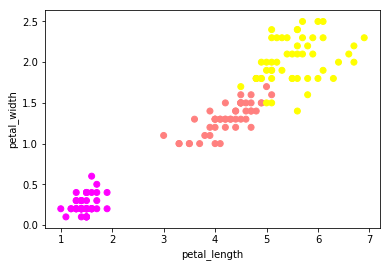

In [3]:
#
# Here we load the IRIS dataset.
# We will create two datasets: one using all features, and one using just Petal Langth and Petal Width for visualizations
#
iris = datasets.load_iris()
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisXFull = np.vstack([np.ones_like(petal_length), iris.data.T])
IrisX2feats = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
IrisY = iris.target.reshape(1,-1).astype(np.int64)

print "IrisXFull is a %s-shaped matrix of %s" % (IrisXFull.shape, IrisXFull.dtype)
print "IrisX2feats is a %s-shaped matrix of %s" % (IrisX2feats.shape, IrisX2feats.dtype)
print "IrisY is a %s-shaped matrix of %s" % (IrisY.shape, IrisY.dtype)

scatter(IrisX2feats[1,:], IrisX2feats[2,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')

In [4]:
def SoftMaxRegression_implementation(ThetaFlat, X, Y=None, return_probabilities=False):
    """
    Compute the outputs of a softmax classifier, or the loss and gradient
    
    Parameters
    ----------
    ThetaFlat : 
        flat array of parameters containing (n_features*n_classes) entries
    X :
        array of features, shape n_features x n_smaples
    Y :
        optional array of desired targets of shape 1 x n_samples
    return_probabilities : 
        if True, the probabilities are returned and Y is not used
        if False, the los and gradient is computed on the X,Y pairs
    """
    #X is num_features x num_samples
    num_features, num_samples = X.shape

    #Theta is num_features x num_classes
    #we first reshape ThetaFlat into Theta
    Theta = ThetaFlat.reshape(num_features, -1)

    #Activation of softmax neurons
    #A's shape should be num_classes x num_samples
    
    A = Theta.T.dot(X)
    #Now compute the SoftMax function
    #O will be a num_classes x num_samples matrix of probabilities assigned by our model  
#     Stability optimization - for each subtract the maximum activation
    O = A - A.max(0, keepdims=True)
    Exps = exp(O)
    O = Exps / (np.sum(Exps, axis=0))
    # TODO - compute SoftMax as vector O. Take the exp and normalize, so all values of O
    #        would sum to 1.0.
    #

    if return_probabilities:
        return O
    
    #The loss is the average per-sample nll (neg log likelihood)
    #The nll is the sum of the logarithms of probabilities assigned to each class
    correct_class_likelihoods = np.log(O[Y.ravel(), np.arange(num_samples)])
    L = - 1.0/num_samples * np.sum(correct_class_likelihoods)

    #For the softmax activation and cross-entropy loss, the derivative dNLL/dA has a simple form
    #Please fill in its computation
    dLdA = np.zeros((O.shape[0], O.shape[1]), dtype=float)
    for i in np.arange(dLdA.shape[0]):
        dLdA[i] = O[i] - (Y[0] == i)
    
    #Now we compute the gradient of the loss with respect to Theta
    dLdTheta = np.dot(X, dLdA.T) / num_samples

    #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
    return L, dLdTheta.reshape(ThetaFlat.shape)

#Make a function for training on irises
iris_log_reg_cost = lambda Theta: SoftMaxRegression_implementation(Theta, IrisXFull, IrisY, False)
check_gradient(iris_log_reg_cost, np.zeros((3*5,)))
check_gradient(iris_log_reg_cost, np.random.rand(3*5)*2.0-1.0)

True

In [5]:
#
# Call a solver
#

#iprint will cause the solver to print TO THE TERMINAL from which ipython notebook was started
ThetaOpt = sopt.fmin_l_bfgs_b(iris_log_reg_cost, np.zeros((3*5,)), iprint=1)[0]
print ThetaOpt
# check_gradient(iris_log_reg_cost, ThetaOpt)

[  4.16729788  19.23717701 -23.40447489   8.02076723  -2.77789602
  -5.24287121  21.04807853  -7.18332972 -13.86474881 -30.75645683
  10.66334381  20.09311302 -14.46175251  -1.91281039  16.3745629 ]


In [6]:
#
# Compute training errors
#

probabilities = SoftMaxRegression_implementation(ThetaOpt, IrisXFull, return_probabilities=True)
predictions = np.argmax(probabilities,0)

print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 98.666667%


In [7]:
#
# Now redo the training for two features
#
# TODO - again, use l_bfgs to find optimal theta, then compute probabilities and new predictions.
#
iris_log_reg_cost2 = lambda Theta: SoftMaxRegression_implementation(Theta, IrisX2feats, IrisY, False)
Theta2class = sopt.fmin_l_bfgs_b(iris_log_reg_cost2, np.zeros((3*3,)), iprint=1)[0]

probabilities2 = SoftMaxRegression_implementation(Theta2class, IrisX2feats, return_probabilities=True)
predictions2 = np.argmax(probabilities,0)

print "Training accurracy: %f%%" % ((predictions2==IrisY.ravel()).mean()*100)

Training accurracy: 98.666667%


In [8]:
#
# Now plot the decision boundary
# 

petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2feats[1,:].min(), IrisX2feats[1,:].max(), 100),
                                          np.linspace(IrisX2feats[2,:].min(), IrisX2feats[2,:].max(), 100))

IrisXGrid = np.vstack([np.ones(np.prod(petal_lengths.shape)), petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = SoftMaxRegression_implementation(Theta2class, IrisXGrid, return_probabilities=True).argmax(0)

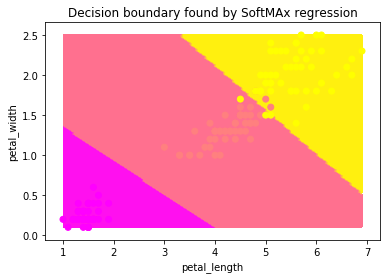

In [9]:
contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(IrisX2feats[1,:], IrisX2feats[2,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by SoftMAx regression')

## 2-layer Neural Network

The task is to extend the SoftMax regression model to a 2-layer neural net.
The network will transform an input vector to an activation vector
of hidden neurons and finally, using the SoftMax function,
to a vector of probabilities of the sample's belonging to one of 10 classes.

To train the network, we'll need the loss function $J$ and its gradient
with respect to network's parameters (weights and biases).
For a 2-layer net, this can be achieved using the following relationships:

### Data

The training set has $m$ samples of $n$ dimensions, belonging to one
of $K$ classes, it is given as a set of matrices: $X \in \mathbb{R}^{n\times m}$
and $Y\in \{1,2,\ldots,K\}^{1\times m}$.

### Parameters

The net will have 2 layers: 1) a hidden one, having $L$ neurons,
and 2) an output one, having $K$ neurons (one for each of $K$ classes).
The layers are defined through:


1. the parameters of the hidden layer, which maps $n$-dimensional input vectors
  into activations of $L$ neurons:
  weight matrix $W^h\in\mathbb{R}^{L\times n}$ and bias vector
  $b^h\in\mathbb{R}^{L\times 1}$,
  
2. the parameters of the output layer, which maps $L$-dimensional vector
  of activations of the hidden layer to $K$ activations of output neurons:
  weight matrix $W^o\in{K\times L}$ and bias vector $b^o\in\mathbb{R}^{K\times 1}$.

### Signal forward propagation (fprop)

Each hidden neuron computes its total input as a sum of product of its
inputs, weight matrix and bias. For an $i$-th sample,
the total input
${a^{h}}^{(i)}_l $ of an $I$-th neuron is thus:
\begin{equation}
{a^h}^{(i)}_l = \sum_{j=1}^n {W^h}_{l,j}x^{(i)}_j + {b^h}_l
\end{equation}
The total input of neurons might also be expressed via matrices,
using matrix multiplication and broadcasting (which allows to add
a column vector to all column vectors of a matrix):
\begin{equation}
{a^h} = W^h\cdot x + b^h
\end{equation}
This can be implemented in Python as `ah = W.dot(x) + b`.

Next, we compute activation $h^h$ of hidden neurons with hyperbolic tangent
$\tanh(a) = \frac{e^a-e^{-a}}{e^a+e^{-a}}$:
\begin{equation}
{h^h}^{(i)}_l=\tanh({a^h}^{(i)}_l)
\end{equation}
Thanks to vectorization in Python + numpy, $h^h$ might be computed with a single
expression `hh = numpy.tanh(ah)`.

Total input of the output layer can be computed using
activations of the hidden layer (with the help of broadcasting) as:

\begin{equation}
a^o = W^o\cdot h^h + b^o
\end{equation}

Finally, probabilities of a sample's belonging to  particular classes
have to be computed. This can be achieved with SoftMax:

\begin{equation}
    p(y^{(i)}=k|x^{(i)}) = o^{(i)}_k = \frac{\exp({a^o}^{(i)}_k)}{ \sum_{k'=1}^K \exp( {a^o}^{(i)}_{k'} )}.
\end{equation}

Like with SoftMax regression, we will use cross-entropy
as the loss function:

\begin{equation}
\begin{split}
J^{(i)}(\Theta) &= - \sum_{k=1}^{K} [y^{(i)}=k]\log o_k^{(i)}, \\
J(\Theta) &= \frac{1}{m}\sum_{i=1}^m J^{(i)}(\Theta)= -\frac{1}{m}\sum_{i=1}^n\sum_{k=1}^{K} [y^{(i)}=k]\log o_k^{(i)}.
\end{split}
\end{equation}

### Error backpropagation (bprop)

Using the chain rule one can derive the gradient of the loss function
in respect to neurons' activations and network parameters.


First we compute the gradient with respect to the output layer's
total inputs:

\begin{equation}
    \frac{\partial J}{\partial {a^o}^{(i)}_k} = \frac{1}{m}(o_k^{(i)} - [y^{(i)}=k]),
\end{equation}

then we compute the gradient with respect to activations of hidden units:

\begin{equation}
    \frac{\partial J}{\partial {h^h}^{(i)}_l} = \sum_{k=1}^K \frac{\partial J}{\partial {a^o}^{(i)}_k} \frac{\partial {a^o}^{(i)}_k}{\partial {h^h}^{(i)}_l} =  \sum_{k=1}^K \frac{\partial J}{\partial {a^o}^{(i)}_k} {W^o}_{kl},
\end{equation}
then we compute the gradient with respect to the total activations of hidden units:

\begin{equation}
    \frac{\partial J}{\partial {a^h}^{(i)}_l} = \frac{\partial J}{\partial {h^h}^{(i)}_l}\frac{\partial {h^h}^{(i)}_l}{\partial {a^h}^{(i)}_l} = \frac{\partial J}{\partial {h^h}^{(i)}_l} (1 - ({h^h}^{(i)}_l)^2),
\end{equation}

where we have used the relationship

$\frac{\partial \tanh(x)}{\partial x} = 1-\tanh(x)^2$.

Finally we can use the gradients with respect to the total inputs to
compute the gradients with respect to network parameters,
eg. for the input layer:

\begin{equation}
    \frac{\partial J}{\partial {W^o}_{kl}} = \sum_{i}\frac{\partial J}{\partial {a^o}^{(i)}_k}\frac{\partial {a^o}^{(i)}_k}{\partial {W^o}_{kl}} = \sum_{i}\frac{\partial J}{\partial {a^o}^{(i)}_k}{h^h}^{(i)}_l,
\end{equation}

\begin{equation}
    \frac{\partial J}{\partial {b^o}_{k}} = \sum_{i}\frac{\partial J}{\partial {a^o}^{(i)}_k}\frac{\partial {a^o}^{(i)}_k}{\partial {b^o}_{k}} = \sum_{i}\frac{\partial J}{\partial {a^o}^{(i)}_k}.
\end{equation}

## Problem 3 [2p]
  Implement a 2-layer neural network as a function
  **TwoLayerNet($\Theta$,X,Y)**
  which computes the loss and gradient of loss with
  respect to the weights and bias terms (encoded as $\Theta$)
  on data given as $X$ and $Y$.
  Refer to the Starter Code below for the details.
  Try to express as much as possible with matrix calculus.

  The following problems will require to train the network.
  Use the L-BFGS optimizer from `scipy.optimize` to minimize
  your function (particularly: the loss) and find the right $\Theta$.

In [10]:
def TwoLayerNet_implementation(ThetaFlat, ThetaShapes, X, Y=None, return_probabilities=False):
    """
    Compute the outputs of a softmax classifier, or the loss and gradient
    
    Parameters
    ----------
    ThetaFlat : 
        flat array of parameters
    ThetaShapes :
        list of shapes of weight and bias matrices
    X :
        array of features, shape n_features x n_smaples
    Y :
        optional array of desired targets of shape 1 x n_samples
    return_probabilities : 
        if True, the probabilities are returned and Y is not used
        if False, the los and gradient is computed on the X,Y pairs
    """
    #X is num_features x num_samples
    num_features, num_samples = X.shape

    #Extract weight matrices
    W1, W2 = decode_params(ThetaFlat, ThetaShapes)
    
    X_padded = np.vstack([np.ones((1, num_samples)), X])
    #Activation in first layer. Shape is num_hidden x num_samples

    A1 = W1.T.dot(X_padded)
    
    #Apply the transfer function

    H1 = np.tanh(A1)
     
    #Pad with zeros
#     print H1.shape
    H1_padded = np.vstack([np.ones((1, num_samples)), H1])
    
    #Now apply the second linear transform

    A2 = W2.T.dot(H1_padded)
    
    #Now compute the SoftMax function
    #O will be a num_classes x num_samples matrix of probabilities assigned by our model  
    #Stability optimization - for each subtract the maximum activation
    O = A2 - A2.max(0, keepdims=True)
    # 
    
    Exps = exp(O)
    O = Exps / (np.sum(Exps, axis=0))

    if return_probabilities:
        return O
    
    #The loss is the average per-sample nll (neg log likelihood)
    #The nll is the sum of the logarithms of probabilities assigned to each class
    correct_class_likelihoods = np.log(O[Y.ravel(), np.arange(num_samples)])
    L = - 1.0/num_samples * np.sum(correct_class_likelihoods)
    
    #For the softmax activation and cross-entropy loss, the derivative dNLL/dA has a simple form
    #Please fill in its computation
    
    dLdA2 = np.zeros((O.shape[0], O.shape[1]), dtype=float)
    for i in np.arange(dLdA2.shape[0]):
        dLdA2[i] = O[i] - (Y[0] == i)
        
    dLdA2 /= num_samples

    dLdH1_padded = W2.dot(dLdA2)
    dLdH1 = dLdH1_padded[1:,:] #ship the derivatives backpropagated to the added ones
    
    quad_H1 = H1 * H1
#     print quad_H1.shape, dLdH1.shape
    dLdA1 = dLdH1 * (-quad_H1 + 1)
#     print dLdH1.shape, quad_H1.shape

#     X_padded2 = np.vstack([np.zeros((1, num_samples)), X])
    dLdW1 = dLdA1.dot(X_padded.T).T
#     print dLdW1.shape
#     dLdW1 = dLdA1.T.dot(X_padded.T)
#     print H1.dot(X_padded.T).shape, dLdW1.shape
    dLdW2 = dLdA2.dot(H1_padded.T).T
    # TODO - compute the derivatives dLdW2 and dLdW1
    # Hint - to compute dLdW1, start with dLdA1

    dLdThetaFlat, unused_shapes = encode_params([dLdW1, dLdW2])
#     print len(dLdThetaFlat)
#     print np.array(dLdThetaFlat).shape
    #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
    return L, dLdThetaFlat

## Problem 4 [1p] (choosing the initial vector)
  In the cases of linear and logistic regression,
  we could start the optimization with a vector of zeros.
  Such initialization will be troublesome for neural networks.

  You can use the following initialization methods for
  network parameters: a) initialize weight matrices with small random
  numbers (eg. drawn from $\mathcal{N}(0, 0.2)$), b) initialize bias
  vectors with zeros. Train the network on the Iris dataset and report
  classification accuracy.

In [11]:
#
# Here we init the network for gradient testing on IRIS
#
# We will have 7 hidden neurons.
# The first weight matrix will be 5 (4 features + bias) x 7 (hidden neurons)
# The second weight matrix will be 8 (7 neurons + bias) x 3 (classes)
#
num_hidden = 7
#
# TODO
W1 = np.random.normal(0, 0.2, 35).reshape(5,7)
W1[0] = np.zeros(7, dtype=float)

W2 = np.random.normal(0, 0.2, 24).reshape(8,3)
W2[0] = np.zeros(3, dtype=float)

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

#Make a function for training on irises
iris_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, iris.data.T, IrisY, False)
#Make sure that the gradient computation is OK
check_gradient(iris_net_cost, Theta0)
check_gradient(iris_net_cost, np.zeros_like(Theta0))
check_gradient(iris_net_cost, np.ones_like(Theta0)*0.01)

True

In [12]:
#
# TODO - apply L-BFGS to minimize the loss and get optimal ThetaOpt.
#

ThetaOpt = sopt.fmin_l_bfgs_b(iris_net_cost, Theta0, iprint=1)[0]

predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, iris.data.T, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 99.333333%


## Problem 5 [1p + 1p bonus]

### XOR network
Test your network on a 2-dimensional and a 3-dimensional
XOR problem. How many hidden neurons the network requires to express
the XOR function?

### Iris network
Normalize the Iris dataset, so that each of the 4 attributes
would fall into {[}-1,1{]} interval. Train the network and check classification
accuracy.

### Bonus
Plot samples (for XOR or for Iris) in hidden neurons' activation space
(similarly to http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/).

  
  

In [13]:
XOR2X = np.array([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).T
XOR2Y = np.array([[0,1,1,0]])

In [31]:
#init the neurons
num_hidden = 2
W1 = (np.random.rand(3,num_hidden) - 0.5)
W2 = (np.random.rand(num_hidden+1,2) -0.5)

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

XOR2_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, XOR2X, XOR2Y, False)
ThetaOpt = sopt.fmin_l_bfgs_b(XOR2_net_cost, Theta0, iprint=1)[0]

TwoLayerNet_implementation(ThetaOpt, ThetaShape, XOR2X, return_probabilities=True).argmax(0)

array([0, 1, 0, 1])

In [32]:
XOR3X = np.array([[0,0,0],
                  [0,0,1],
                  [0,1,0],
                  [1,0,0],
                  [1,1,0],
                  [1,0,1],
                  [0,1,1],
                  [1,1,1]]).T
XOR3Y = np.array([[0,1,1,1,0,0,0,1]])

num_hidden = 3
W1 = (np.random.rand(4,num_hidden) - 0.5)
W2 = (np.random.rand(num_hidden+1,2) -0.5)

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

XOR3_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, XOR3X, XOR3Y, False)
ThetaOpt = sopt.fmin_l_bfgs_b(XOR3_net_cost, Theta0, iprint=1)[0]

TwoLayerNet_implementation(ThetaOpt, ThetaShape, XOR3X, return_probabilities=True).argmax(0)

array([0, 1, 1, 1, 0, 0, 0, 1])

In [ ]:
#
# (Bonus)
# TODO - change network implementation code to return hidden activations.
# Hint - locals() gives the dictionary of all objects in a functions's scope!
#

In [55]:
IrisNX = np.array(iris.data)
IrisNX -= np.min(IrisNX, axis=0)
imax = np.max(IrisNX, axis=0)
IrisNormX = ( (IrisNX - imax / 2.) / imax * 2).T
# print np.max(IrisNormX, axis=1), np.min(IrisNormX, axis=1)
# print IrisNormX

In [56]:
num_hidden = 10

W1 = (np.random.rand(5, num_hidden) - 0.5)*0.1
W2 = (np.random.rand(num_hidden + 1, 3) - 0.5)*0.1

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1, W2])

iris_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, IrisNormX, IrisY, False)
ThetaOpt = sopt.fmin_l_bfgs_b(iris_net_cost, Theta0, iprint=1)[0]

predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, IrisNormX, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 100.000000%


## Problem 6 [1p]

  Final questions:
  
   * Are neural networks parametric (https://en.wikipedia.org/wiki/Parametric_model) or non-parametric (https://en.wikipedia.org/wiki/Non-parametric_model) models? Why is it so?
   
   * What will happen if for each layer (hidden and output) all weights
    will be initialized to the same values before the training?
    
   * How will the value of SoftMax function change,
  if we will add the same constant term to each element of $a$?
  Often, before computing SoftMax, the largest value can be subtracted
  to mitigate large exponents and associated numerical errors.
  Is it a good practice?

   * Are two-class SoftMax regression and logistic regression equivalent (can you build a logistic regression model from a given softmax one and vice versa)?

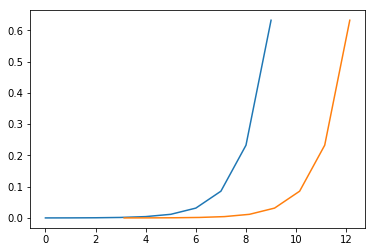

In [6]:
def SoftMax(A):
    O = A - A.max(0, keepdims=True)
    Exps = exp(O)
    O = Exps / (np.sum(Exps, axis=0))
    return O
    
B = np.arange(10, dtype=float)
plot(B, SoftMax(B))
C = B + 3.14
plot(C, SoftMax(C))

## Problem 7 [1p]
You are provided with a starter code for a modular implementation of a
feedforward neural network. Your general task is to fill in the blanks
in the code, and validate the implementation on the IRIS task (ake sure
that the network can be trained on the Iris dataset to reach 100% training
accuracy.)

**Note:** the next assignment list will involve using this code, or other neural 
network implementation that you will be able to fully explain to reach a low
error rate on the mnist dataset.

In [8]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)


In [7]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
    
    @property
    def parameters(self):
        return []
    
    @property
    def parameter_names(self):
        return []
    
    def get_gradients(self, dLdY, fprop_context):
        return []
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(AffineLayer, self).__init__(**kwargs)
        if weight_init is None:
            weight_init = IsotropicGaussian(1., 2.) #Constant(0.)
        if bias_init is None:
            bias_init = Constant(0.0)
        
        self.W = weight_init.generate(self.rng, (num_out, num_in))
        self.b = bias_init.generate(self.rng, (num_out, 1))
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    @property
    def parameter_names(self):
        return ['W','b']
    
    def fprop(self, X):
        #Save X for later reusal
        fprop_context = dict(X=X)
        Y = np.dot(self.W, X) +  self.b
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        dLdX = dLdY.T.dot( self.W ) #fprop_context['X'].T )
#         print "affinelayer:", dLdY.shape, self.W.shape, dLdX.shape
        return dLdX
    
    def get_gradients(self, dLdY, fprop_context):
        X = fprop_context['X']
        dLdW = np.dot(dLdY, X.T)
        dLdb = dLdY.sum(1, keepdims=True)
        return [dLdW, dLdb]
    
class TanhLayer(Layer):
    def __init__(self, **kwargs):
        super(TanhLayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.tanh(X)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
#         print "tanhlayer:", dLdY.shape, Y.shape, dLdY.dot(Y).shape
        return dLdY.T * (-(Y * Y) + 1) #dLdY.dot(Y)

    
class ReLULayer(Layer):
    def __init__(self, **kwargs):
        super(ReLULayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.maximum(X, 0.0)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        return dLdY * (Y>0)

    
class SoftMaxLayer(Layer):
    def __init__(self, **kwargs):
        super(SoftMaxLayer, self).__init__(**kwargs)
    
    def compute_probabilities(self, X):
        O = X - X.max(axis=0, keepdims=True)
        O = np.exp(O)
        O /= O.sum(axis=0, keepdims=True)
        return O
    
    def fprop_cost(self, X, Y):
        NS = X.shape[1]
        O = self.compute_probabilities(X)
        Cost = -1.0/NS * np.log(O[Y.ravel(), range(NS)]).sum()
        return Cost, O, dict(O=O, X=X, Y=Y)
    
    def bprop_cost(self, fprop_context):
        X = fprop_context['X']
        Y = fprop_context['Y']
        O = fprop_context['O']
        NS = X.shape[1]
        dLdX = O.copy()
        dLdX[Y, range(NS)] -= 1.0
        dLdX /= NS
        return dLdX
    
class FeedForwardNet(object):
    def __init__(self, layers=None):
        if layers is None:
            layers = []
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP[...] = newP
    
    @property
    def parameter_names(self):
        param_names = []
        for layer in self.layers:
            param_names += layer.parameter_names
        return param_names
    
    def fprop(self, X):
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
        return self.layers[-1].compute_probabilities(X)
    
    def get_cost_and_gradient(self, X, Y):
        fp_contexts = []
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
            fp_contexts.append(fp_context)
        
        L, O, fp_context = self.layers[-1].fprop_cost(X, Y)
        dLdX = self.layers[-1].bprop_cost(fp_context)
        
        dLdP = [] #gradient with respect to parameters
        for i in xrange(len(self.layers)-1):
            layer = self.layers[len(self.layers)-2-i]
            fp_context = fp_contexts[len(self.layers)-2-i]
            dLdP = layer.get_gradients(dLdX, fp_context) + dLdP
            dLdX = layer.bprop(dLdX, fp_context)
        return L, O, dLdP


In [9]:
#training algorithms. They change the network!
def GD(net, X, Y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """
    Simple batch gradient descent
    """
    old_L = np.inf
    for i in xrange(max_iters):
        L, O, gradients = net.get_cost_and_gradient(X, Y)
        if old_L < L:
            print "Iter: %d, loss increased!!" % (i,)
        if (old_L - L)<tolerance:
            print "Tolerance level reached exiting"
            break
        if i % 1000 == 0:
            err_rate = (O.argmax(0) != Y).mean()
            print "At iteration %d, loss %f, train error rate %f%%" % (i, L, err_rate*100)
        for P,G in zip(net.parameters, gradients):
            P -= alpha * G
        old_L = L

In [10]:
from sklearn import datasets
iris = datasets.load_iris()
IrisX = iris.data.T
IrisX = (IrisX - IrisX.mean(axis=1, keepdims=True)) / IrisX.std(axis=1, keepdims=True)
IrisY = iris.target.reshape(1,-1)

In [11]:
net = FeedForwardNet([
        AffineLayer(4,10),
        TanhLayer(),
        AffineLayer(10,3),
        SoftMaxLayer()
        ])
GD(net, IrisX,IrisY, 1e-1, tolerance=1e-7, max_iters=50000)


At iteration 0, loss 0.784873, train error rate 31.333333%
At iteration 1000, loss 0.213607, train error rate 8.666667%
At iteration 2000, loss 0.048379, train error rate 1.333333%
At iteration 3000, loss 0.025394, train error rate 0.000000%
At iteration 4000, loss 0.017904, train error rate 0.000000%
At iteration 5000, loss 0.013691, train error rate 0.000000%
At iteration 6000, loss 0.011161, train error rate 0.000000%
At iteration 7000, loss 0.009492, train error rate 0.000000%
At iteration 8000, loss 0.008294, train error rate 0.000000%
At iteration 9000, loss 0.007378, train error rate 0.000000%
At iteration 10000, loss 0.006650, train error rate 0.000000%
At iteration 11000, loss 0.006054, train error rate 0.000000%
At iteration 12000, loss 0.005556, train error rate 0.000000%
At iteration 13000, loss 0.005133, train error rate 0.000000%
At iteration 14000, loss 0.004769, train error rate 0.000000%
At iteration 15000, loss 0.004453, train error rate 0.000000%
At iteration 16000, 